In [1]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.ticker import FormatStrFormatter as fsf
from plots.mpltoolkit import mpl_loc, named_colors, markers, fancy_legend, negative_log, load_style_sheet
import numpy as np
import functools
import vice
import sys
sys.path.append("..")
from src.utils import get_velocity_profile, oh_to_12pluslog, get_velocity_evolution
from src.plots.utils import weighted_median
load_style_sheet("papers")
print(sys.version_info)

/Users/jamesjohnson/Work/Research/lib/public-dev/VICE/vice/__init__.py:141: UserWarning: Using un-released version of VICE
  warnings.warn("Using un-released version of VICE", UserWarning)


sys.version_info(major=3, minor=12, micro=3, releaselevel='final', serial=0)


In [5]:
output = vice.output("../outputs/expifr_gse/amd/tacc3p2/massratio3/expsigma/gsebetaphiin-0p8")

frame = 0

/Users/jamesjohnson/Work/Research/lib/personal/plots/mpltoolkit/core.py:96: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(labels)


frame = 1320

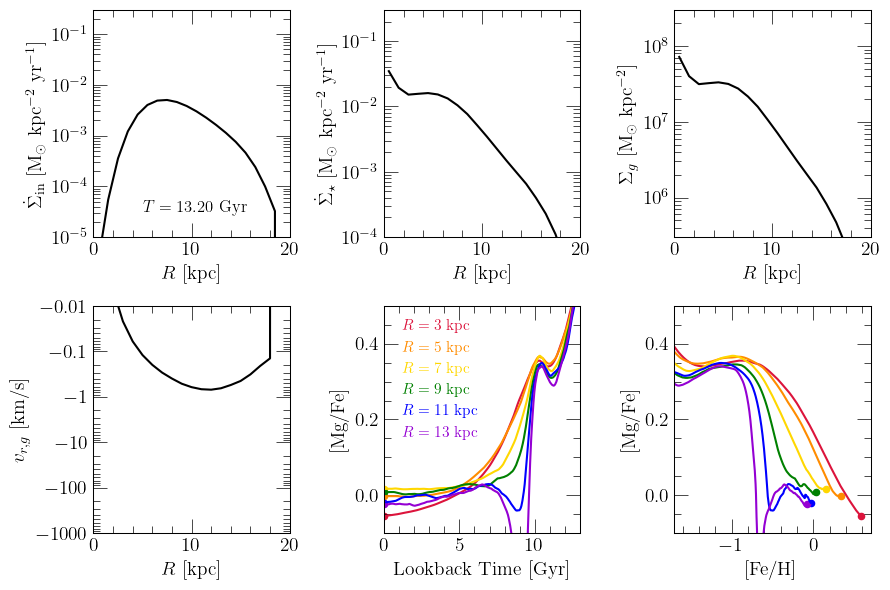

In [6]:
RADII = [3, 5, 7, 9, 11, 13]
COLORS = ["crimson", "darkorange", "gold", "green", "blue", "darkviolet"]

fig = plt.figure(figsize = (9, 6))
axes = []
for i in range(6):
    axes.append(fig.add_subplot(231 + i))
    if i < 4:
        axes[i].set_yscale("log")
        axes[i].set_xlabel(r"$R$ [kpc]")
        axes[i].set_xlim([0, 20])
    else: pass
axes[0].set_ylabel(r"$\dot \Sigma_\text{in}$ [M$_\odot$ kpc$^{-2}$ yr$^{-1}$]")
axes[1].set_ylabel(r"$\dot \Sigma_\star$ [M$_\odot$ kpc$^{-2}$ yr$^{-1}$]")
axes[2].set_ylabel(r"$\Sigma_g$ [M$_\odot$ kpc$^{-2}$]")
axes[3].set_ylabel(r"$v_{r,g}$ [km/s]")
axes[0].set_ylim([1.e-5, 0.3])
axes[1].set_ylim([1.0e-4, 0.3])
axes[2].set_ylim([3.0e5, 3.0e8])
# axes[3].set_ylim([-10, 0])
axes[3].set_ylim([0.01, 1000])
axes[3].yaxis.set_major_formatter(fsf("%g"))
negative_log(axes[3])

axes[4].set_xlabel(r"Lookback Time [Gyr]")
axes[4].set_ylabel(r"[Mg/Fe]")
axes[4].set_xlim([0, 13])
axes[4].set_ylim([-0.1, 0.5])

axes[5].set_xlabel(r"[Fe/H]")
axes[5].set_ylabel(r"[Mg/Fe]")
axes[5].set_xlim([-1.7, 0.7])
axes[5].set_ylim([-0.1, 0.5])

# zone_width = 0.1
zone_width = 1
timestamp = axes[0].text(5, 3.0e-5, r"$T = 0.00$ Gyr", fontsize = 12)
radii = [zone_width * (i + 0.5) for i in range(len(output.zones.keys()))]
ifrline, = axes[0].plot([], [], c = named_colors()["black"])
sfrline, = axes[1].plot([], [], c = named_colors()["black"])
gasline, = axes[2].plot([], [], c = named_colors()["black"])
vline, = axes[3].plot([], [], c = named_colors()["black"])
mgfelines = []
tracks = []
mgfepoints = []
trackpoints = []
for i in range(len(RADII)):
    kwargs = {
        "c": named_colors()[COLORS[i]],
        "label": r"$R = %g$ kpc" % (RADII[i])
    }
    mgfelines.append(axes[4].plot([], [], **kwargs)[0])
    tracks.append(axes[5].plot([], [], **kwargs)[0])
    kwargs["label"] = None
    mgfepoints.append(axes[4].scatter([100], [0], **kwargs, s = 20))
    trackpoints.append(axes[5].scatter([100], [0], **kwargs, s = 20))

def init():
    return [ifrline, sfrline, gasline]

def update(frame):
    sys.stdout.write("\rframe = %d" % (frame))
    sys.stdout.flush()
    timestamp.set_text(r"$T = %.2f$ Gyr" % (output.zones["zone0"].history["time"][frame]))
    sigma_ifr = []
    sigma_sfr = []
    sigma_gas = []
    for i in range(len(radii)):
        area = np.pi * ((radii[i] + zone_width / 2)**2 - (radii[i] - zone_width / 2)**2)
        zone = output.zones["zone%d" % (i)]
        sigma_ifr.append(zone.history["ifr"][frame] / area)
        sigma_sfr.append(zone.history["sfr"][frame] / area)
        sigma_gas.append(zone.history["mgas"][frame] / area)
    ifrline.set_xdata(radii)
    sfrline.set_xdata(radii)
    gasline.set_xdata(radii)
    ifrline.set_ydata(sigma_ifr)
    sfrline.set_ydata(sigma_sfr)
    gasline.set_ydata(sigma_gas)
    r, vgas = get_velocity_profile(output, output.zones["zone0"].history["lookback"][frame])
    vline.set_xdata(r)
    vline.set_ydata([-v for v in vgas])
    for i in range(len(RADII)):
        zone = int(RADII[i] / zone_width)
        zone = output.zones["zone%d" % (zone)]
        mgfelines[i].set_xdata(zone.history["lookback"][:frame])
        mgfelines[i].set_ydata(zone.history["[mg/fe]"][:frame])
        tracks[i].set_xdata(zone.history["[fe/h]"][:frame])
        tracks[i].set_ydata(zone.history["[mg/fe]"][:frame])
        mgfepoints[i].set_offsets((zone.history["lookback"][frame], zone.history["[mg/fe]"][frame]))
        trackpoints[i].set_offsets((zone.history["[fe/h]"][frame], zone.history["[mg/fe]"][frame]))
    return [ifrline, sfrline, gasline]

kwargs = {
    "loc": mpl_loc("upper left"),
    "fontsize": 11,
    "handlelength": 0
}
leg = axes[4].legend(**kwargs)
fancy_legend(leg, COLORS)

# nframes = len(output.zones["zone0"].history["time"])
# print("nframes = %d" % (nframes))
framenumbers = list(range(0, len(output.zones["zone0"].history["time"]), 2))
plt.tight_layout()
ani = animation.FuncAnimation(fig, update, repeat = True, blit = True, interval = 50, init_func = init, frames = framenumbers)
writer = animation.FFMpegWriter(fps = 50)
# for ext in ["mp4", "gif"]: ani.save("test.%s" % (ext), writer = writer)
# for ext in ["mp4", "gif"]: ani.save("test2.%s" % (ext), writer = writer)
ani.save("test4.mp4", writer = writer)
plt.show()